# Experiments with more difficult query workloads

## Imports and setup

In [5]:
import pandas as pd  # type: ignore
import numpy as np  # type: ignore

import matplotlib.pyplot as plt  # type: ignore
from matplotlib.ticker import MaxNLocator  # type: ignore

from sklearn.manifold import TSNE  # type: ignore
from sklearn.decomposition import PCA  # type: ignore
from sklearn.preprocessing import StandardScaler  # type: ignore

from sklearn.model_selection import train_test_split  # type: ignore
from sklearn.linear_model import LinearRegression  # type: ignore
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import json
import lightgbm as lgb

dataset_params = {
        "SIFT100M": {
            "M": 32,
            "efC": 500,
            "efS": 500,
            "color": "lightblue",
            "marker": "o",
            "li": 1,
            "label": "SIFT100M"
        },
        "DEEP100M": {
            "M": 32,
            "efC": 500,
            "efS": 750,
            "color": "plum",
            "marker": "x",  
            "li": 1 ,
            "label": "DEEP100M"
        },
        "T2I100M": {
            "M": 80,
            "efC": 1000,
            "efS": 2500,
            "color": "rosybrown",
            "marker": "d",
            "li": 2,
            "label": "T2I100M"
        },
        "GLOVE100": {
            "M": 16,
            "efC": 500,
            "efS": 500,
            "color": "orange",
            "marker": "^",
            "li": 1,
            "label": "GLOVE1M"
        },
        "GIST1M": {
            "M": 32,
            "efC": 500,
            "efS": 1000,
            "color": "lightgreen",
            "marker": "s",
            "li": 1,
            "label": "GIST1M"
        },
    }

interval_conf = {}
with open("../../experiments/generated_json/final_heuristic_adaptive_recommendations_params_ipidiv2_mpidiv10.json") as f:
    interval_conf = json.load(f)

laet_multiplier_conf = {}
with open("../../experiments/generated_json/laet_tuning_results_memoryFalse_validationSize1000.json") as f:
    laet_multiplier_conf = json.load(f)

classic_hnsw_conf = {}
with open("../../experiments/generated_json/classic_hnsw_tuning_results_memoryFalse_validationSize1000.json") as f:
    classic_hnsw_conf = json.load(f)
    
algorithm_conf = {
    "Plain-HNSW":{
        "color": "red",
        "marker": "D",
        "label": "Plain-HNSW",
    },
    "Naive-Baseline": {
        "color": "black",
        "marker": "s",
        "label": "Baseline",
    },
    "LAET": {
        "color": "gray",
        "marker": "x",
        "label": "LAET",
    },
    "HNSW": {
        "color": "lightgray",
        "marker": "^",
        "label": "REM",
    },
    "DARTH": {
        "color": "tomato",
        "marker": "o",
        "label": "DARTH",
    },
}

def rqut_calculator(df, s, r_target, recall_col="r"):
    return len(df[df[recall_col] < r_target]) / s

def rde_calculator(df, s, r_target, recall_col="r"):
    return df["RDE"].mean()

def tde_calculator(df, s, r_target, recall_col="r"):
    new_df = df[df["TDR"] > 0]
    return new_df["TDR"].mean()

def nrs_rev_calculator(df, s, r_target, recall_col="r"):
    #return 1/df["NRS"].mean()
    return 1/df[df["NRS"] > 0]["NRS"].mean()

def nrs_calculator(df, s, r_target, recall_col="r"):
    # remove the negative entries from the df:
    new_df = df[df["NRS"] > 0]
    return new_df["NRS"].mean()

def time_calculator(df, s, r_target, recall_col="r"):
    return df["elaps_ms"].mean()

def dist_calculation(df, s, r_target, recall_col="r"):
    return df["dists"].mean()

def p99_calculation(df, s, r_target, recall_col="r"):
    below_df = df[df[recall_col] <= r_target]
    error = np.abs(below_df[recall_col] - r_target)
    return np.percentile(error, 99)

def error_mean_calculation(df, s, r_target, recall_col="r"):
    below_df = df[df[recall_col] < r_target]    
    return below_df[recall_col].mean()

def worst_errors_calculation(df, s, r_target, recall_col="r"):
    below_df = df[df[recall_col] < r_target]    
    return below_df[recall_col].max()

def worst_1perc_errors_mean_calculation(df, s, r_target, recall_col="r"):
    # Filter entries below the target recall
    below_df = df[df[recall_col] < r_target].copy()
    
    # Calculate the error as the absolute difference
    below_df["error"] = abs(r_target - below_df[recall_col])
    
    # Sort the DataFrame by the error in descending order
    sorted_below_df = below_df.sort_values(by="error", ascending=False)
    
    # Calculate the top 1% of the worst errors
    num_entries = len(sorted_below_df)
    worst_1_percent_count = max(1, int(0.01 * num_entries))  # At least 1 entry
    
    # Select the worst 1% errors and calculate their mean
    worst_1_perc_mean = sorted_below_df["error"].head(worst_1_percent_count).mean()
    
    return worst_1_perc_mean

def qps_calculator(df, s, r_target, recall_col="r"):
    average_time_ms = df["elaps_ms"].mean()
    average_time_seconds = average_time_ms / 1000
    qps = 1 / average_time_seconds
    return qps

def recall_calculator(df, s, r_target, recall_col="r"):
    return df[recall_col].mean()

quality_measures = {
    "RQUT": {
        "label": "RQUT",
        "calculator": rqut_calculator,
        "type": "bar"
    },
    "RDE": {
        "label": "RDE",
        "calculator": rde_calculator,
        "type": "bar"
    },
    "TDR": {
        "label": "TDR",
        "calculator": tde_calculator,
        "type": "bar"
    },
    
    "NRS_rev": {
        "label": r"$NRS^{-1}$",
        "calculator": nrs_rev_calculator,
        "type": "bar"
    },
    "NRS": {
        "label": "NRS",
        "calculator": nrs_calculator,
        "type": "bar"
    },
    "Time": {
        "label": "Time (ms)",
        "calculator": time_calculator,
        "type": "line"
    },
    "Dist": {
        "label": "Dists",
        "calculator": dist_calculation,
        "type": "line"
    },
    "p99": {
        "label": r"$P99$",
        "calculator": p99_calculation,
        "type": "bar"
    },
    "ErrorMean": {
        "label": "Error Mean",
        "calculator": error_mean_calculation,
        "type": "bar"
    },
    "WorstErrors": {
        "label": "Worst Errors",
        "calculator": worst_errors_calculation,
        "type": "bar"
    },
    "Worst1perc": {
        "label": "Worst 1%",
        "calculator": worst_1perc_errors_mean_calculation,
        "type": "bar"
    },
    "QPS": {
        "label": "QPS",
        "calculator": qps_calculator,
        "type": "line"
    },
    "Recall": {
        "label": "Recall",
        "calculator": recall_calculator,
        "type": "bar",
        "label": "Actual Recall",
    }
}

PLOTS_DIR = "./../../experiments/revision-plots/"

## Varying noise experiments

Average recall for SIFT100M with noise 1 is 0.99648 for 1000 queries
Average recall for SIFT100M with noise 2 is 0.99576 for 1000 queries
Average recall for SIFT100M with noise 4 is 0.9911200000000001 for 1000 queries
Average recall for SIFT100M with noise 6 is 0.9789200000000001 for 1000 queries
Average recall for SIFT100M with noise 8 is 0.9602600000000001 for 1000 queries
Average recall for SIFT100M with noise 10 is 0.9337000000000001 for 1000 queries
Average recall for SIFT100M with noise 12 is 0.9432679738562092 for 765 queries
Average recall for SIFT100M with noise 14 is 0.87128 for 1000 queries
Average recall for SIFT100M with noise 16 is 0.8495199999999999 for 1000 queries
Average recall for SIFT100M with noise 18 is 0.8266199999999999 for 1000 queries
Average recall for SIFT100M with noise 20 is 0.8066200000000001 for 1000 queries
Average recall for SIFT100M with noise 22 is 0.79132 for 1000 queries
Average recall for SIFT100M with noise 24 is 0.79168 for 1000 queries
Average 

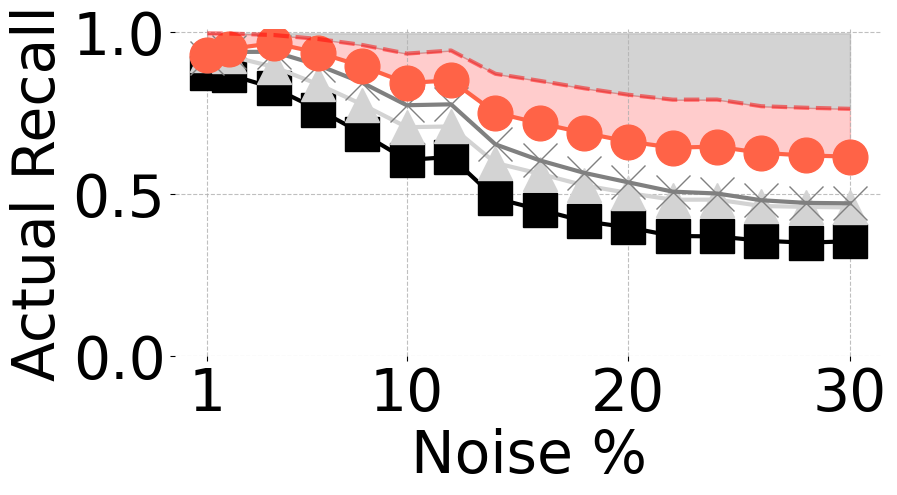

Average recall for GLOVE100 with noise 1 is 0.9931 for 1000 queries
Average recall for GLOVE100 with noise 2 is 0.99222 for 1000 queries
Average recall for GLOVE100 with noise 4 is 0.9875 for 1000 queries
Average recall for GLOVE100 with noise 6 is 0.97214 for 1000 queries
Average recall for GLOVE100 with noise 8 is 0.9423599999999999 for 1000 queries
Average recall for GLOVE100 with noise 10 is 0.90274 for 1000 queries
Average recall for GLOVE100 with noise 12 is 0.9750527903469081 for 663 queries
Average recall for GLOVE100 with noise 14 is 0.78428 for 1000 queries
Average recall for GLOVE100 with noise 16 is 0.71408 for 1000 queries
Average recall for GLOVE100 with noise 18 is 0.6609400000000001 for 1000 queries
Average recall for GLOVE100 with noise 20 is 0.59226 for 1000 queries
Average recall for GLOVE100 with noise 22 is 0.5570600000000001 for 1000 queries
Average recall for GLOVE100 with noise 24 is 0.5181399999999999 for 1000 queries
Average recall for GLOVE100 with noise 26 i

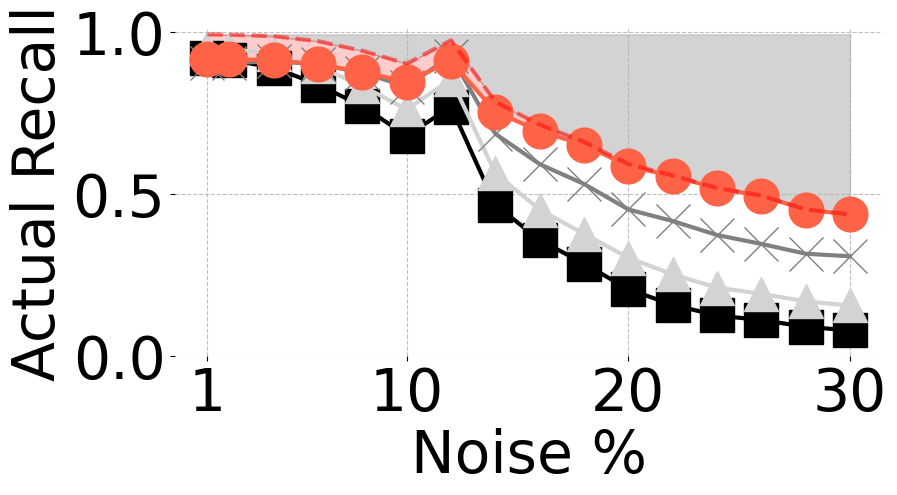

Average recall for GIST1M with noise 1 is 0.9942000000000001 for 1000 queries
Average recall for GIST1M with noise 2 is 0.9894200000000001 for 1000 queries
Average recall for GIST1M with noise 4 is 0.9600599999999999 for 1000 queries
Average recall for GIST1M with noise 6 is 0.9056000000000002 for 1000 queries
Average recall for GIST1M with noise 8 is 0.84086 for 1000 queries
Average recall for GIST1M with noise 10 is 0.77924 for 1000 queries
Average recall for GIST1M with noise 12 is 0.9339299610894941 for 257 queries
Average recall for GIST1M with noise 14 is 0.6850600000000001 for 1000 queries
Average recall for GIST1M with noise 16 is 0.6513199999999999 for 1000 queries
Average recall for GIST1M with noise 18 is 0.6243800000000002 for 1000 queries
Average recall for GIST1M with noise 20 is 0.5940599999999999 for 1000 queries
Average recall for GIST1M with noise 22 is 0.5863 for 1000 queries
Average recall for GIST1M with noise 24 is 0.57112 for 1000 queries
Average recall for GIST1

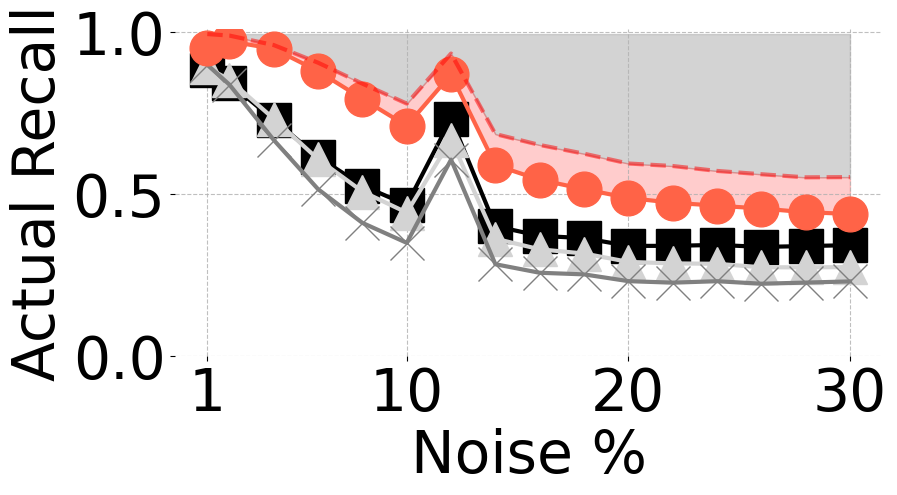

Average recall for DEEP100M with noise 1 is 0.99504 for 1000 queries
Average recall for DEEP100M with noise 2 is 0.99442 for 1000 queries
Average recall for DEEP100M with noise 4 is 0.9925 for 1000 queries
Average recall for DEEP100M with noise 6 is 0.98622 for 1000 queries
Average recall for DEEP100M with noise 8 is 0.9757 for 1000 queries
Average recall for DEEP100M with noise 10 is 0.9609 for 1000 queries
Average recall for DEEP100M with noise 12 is 0.9588153310104529 for 861 queries
Average recall for DEEP100M with noise 14 is 0.9125800000000001 for 1000 queries
Average recall for DEEP100M with noise 16 is 0.882 for 1000 queries
Average recall for DEEP100M with noise 18 is 0.85034 for 1000 queries
Average recall for DEEP100M with noise 20 is 0.8303200000000001 for 1000 queries
Average recall for DEEP100M with noise 22 is 0.80596 for 1000 queries
Average recall for DEEP100M with noise 24 is 0.7821200000000001 for 1000 queries
Average recall for DEEP100M with noise 26 is 0.77162 for 

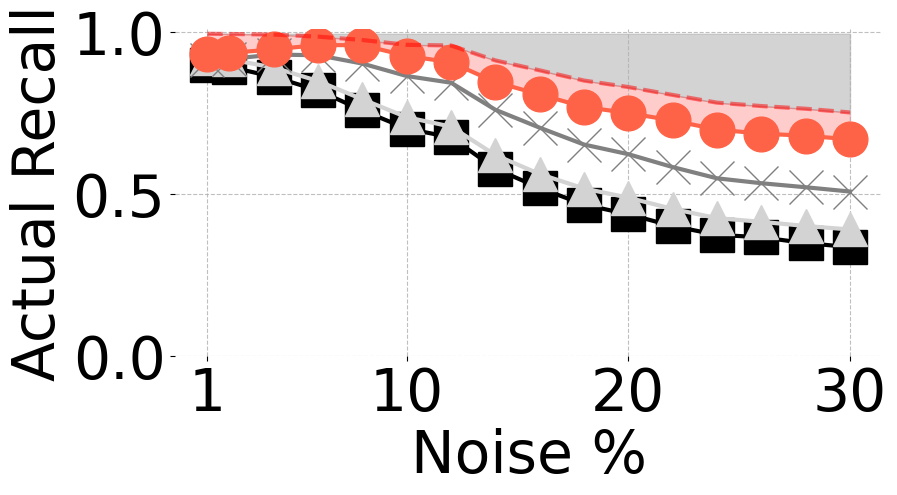

In [3]:
# Noisy experiment:
all_datasets = ["SIFT100M", "GLOVE100", "GIST1M", "DEEP100M"]#, "GLOVE100", "GIST1M"]
all_k_values = ["50"]
s = 1000

# keep the gtaph without the recall
# check if there is evident diff with the results of the original paper

plt.rcParams.update({"font.size": 42})

all_noise_percentages = ["1", "2", "4", "6", "8", "10", "12", "14", "16", "18", "20", "22", "24", "26", "28", "30"]

all_r_targets = ["0.9"]
all_measures = ["Recall"]
for measure in all_measures:
    measure_label = quality_measures[measure]["label"]
    measure_calculator = quality_measures[measure]["calculator"]
    for ds_name in all_datasets:
        M = dataset_params[ds_name]["M"]
        efC = dataset_params[ds_name]["efC"]
        efS = dataset_params[ds_name]["efS"]
        for k in all_k_values:
            for r_target in all_r_targets:
                fig, ax = plt.subplots(figsize=(10,6))
                
                ipi, mpi = interval_conf[ds_name][k][f"{float(r_target):.2f}"]["ipi"], interval_conf[ds_name][k][f"{float(r_target):.2f}"]["mpi"]
                f_r_target = float(r_target)
                
                plain_HNSW_values_per_noise = []
                
                DARTH_values_per_noise = []
                LAET_values_per_noise = []
                HNSW_values_per_noise = []
                naive_values_per_noise = []
                
                for noise_percentage in all_noise_percentages:
                    no_early_stop_df = pd.read_csv(f"../../experiments/results/no-early-stop/testing/{ds_name}/k{k}/noisy/noise{noise_percentage}_M{M}_efC{efC}_efS{efS}_qs{s}.txt", usecols=["qid", "step", "dists", "inserts", "elaps_ms", "r", "RDE", "TDR", "NRS"])
                    if int(noise_percentage) == 12:
                        no_early_stop_df = no_early_stop_df[no_early_stop_df["r"] >= f_r_target-0.05]                
                    
                    average_no_early_stop_recall = no_early_stop_df["r"].mean()
                    print(f"Average recall for {ds_name} with noise {noise_percentage} is {average_no_early_stop_recall} for {len(no_early_stop_df)} queries")
                    
                    darth_df = pd.read_csv(f"../../experiments/results/early-stop-testing/{ds_name}/k{k}/noisy/noise{noise_percentage}_M{M}_efC{efC}_efS{efS}_qs{s}_tr{f_r_target:.2f}_ipi{ipi}_mpi{mpi}.txt", usecols=["qid", "step", "dists", "inserts", "elaps_ms", "r_actual", "r_predicted", "r_predictor_calls", "r_predictor_time_ms", "RDE", "TDR", "NRS"])
                    naive_df = pd.read_csv(f"../../experiments/results/naive-early-stop-testing/{ds_name}/k{k}/noisy/noise{noise_percentage}_M{M}_efC{efC}_efS{efS}_qs{s}_tr{f_r_target:.2f}.txt", usecols=["qid", "elaps_ms", "dists", "r", "RDE", "TDR", "NRS"])
                    laet_df  = pd.read_csv(f"../../experiments/results/laet-early-stop-testing/{ds_name}/k{k}/noisy/noise{noise_percentage}_M{M}_efC{efC}_efS{efS}_qs{s}_tr{f_r_target:.2f}.txt", usecols=["qid", "elaps_ms", "dists", "predicted_distance_calcs", "r", "RDE", "TDR", "NRS"])
                    cefs = classic_hnsw_conf[ds_name][k][r_target]["min_efS"]
                    hnsw_df  = pd.read_csv(f"../../experiments/results/classic-hnsw/{ds_name}/k{k}/noisy/noise{noise_percentage}_M{M}_efC{efC}_efS{cefs}_qs{s}_tr{f_r_target:.2f}.txt", usecols=["qid", "elaps_ms", "dists", "r", "RDE", "TDR", "NRS"])
                        
                    darth_df = darth_df[darth_df["qid"].isin(no_early_stop_df["qid"])]
                    naive_df = naive_df[naive_df["qid"].isin(no_early_stop_df["qid"])]
                    laet_df = laet_df[laet_df["qid"].isin(no_early_stop_df["qid"])]
                    hnsw_df = hnsw_df[hnsw_df["qid"].isin(no_early_stop_df["qid"])]

                    measure_plain_HNSW = measure_calculator(no_early_stop_df, s, f_r_target)
                    measure_darth = measure_calculator(darth_df, s, f_r_target, recall_col="r_actual")
                    measure_laet = measure_calculator(laet_df, s, f_r_target)
                    measure_naive = measure_calculator(naive_df, s, f_r_target)
                    measure_hnsw = measure_calculator(hnsw_df, s, f_r_target)

                    plain_HNSW_values_per_noise.append(measure_plain_HNSW)
                    DARTH_values_per_noise.append(measure_darth)    
                    LAET_values_per_noise.append(measure_laet)
                    naive_values_per_noise.append(measure_naive)
                    HNSW_values_per_noise.append(measure_hnsw)
                
                x = [int(noise_perc) for noise_perc in all_noise_percentages]
                markersize = 25
                linewidth = 3
                ax.plot(x, naive_values_per_noise, color=algorithm_conf["Naive-Baseline"]["color"], marker=algorithm_conf["Naive-Baseline"]["marker"], label=algorithm_conf["Naive-Baseline"]["label"], markersize=markersize, linewidth=linewidth)
                ax.plot(x, HNSW_values_per_noise, color=algorithm_conf["HNSW"]["color"], marker=algorithm_conf["HNSW"]["marker"], label=algorithm_conf["HNSW"]["label"], markersize=markersize, linewidth=linewidth)
                ax.plot(x, LAET_values_per_noise, color=algorithm_conf["LAET"]["color"], marker=algorithm_conf["LAET"]["marker"], label=algorithm_conf["LAET"]["label"], markersize=markersize, linewidth=linewidth)
                ax.plot(x, DARTH_values_per_noise, color=algorithm_conf["DARTH"]["color"], marker=algorithm_conf["DARTH"]["marker"], label=algorithm_conf["DARTH"]["label"], markersize=markersize, linewidth=linewidth)
                
                
                ax.plot(x, plain_HNSW_values_per_noise, color=algorithm_conf["Plain-HNSW"]["color"], label=algorithm_conf["Plain-HNSW"]["label"], markersize=15, linewidth=linewidth, linestyle="--", alpha=0.5)
                ax.fill_between(x, plain_HNSW_values_per_noise, max(plain_HNSW_values_per_noise), color="darkgray", alpha=0.5)
                
                # fill between the plain HNSW and the DARTH
                ax.fill_between(x, plain_HNSW_values_per_noise, DARTH_values_per_noise, color="red", alpha=0.2)
                
                ax.grid(alpha=0.8, linestyle="--")
                
                for spine in ax.spines.values():
                    spine.set_visible(False)

                ax.set_xlabel("Noise %")
                ax.set_ylabel(measure_label)
                
                # make y-axis log scale
                #ax.set_yscale("log")
                
                ticks = ax.get_yticks()
                ticks = [0.0, 0.5, 1.0]#f_r_target]
                
                ax.set_yticks(sorted(ticks))
                ax.set_ylim(bottom=0, top=1.01)
                
                # set x-axis labels to be the recall levels
                ax.set_xticks([1, 10, 20, 30])
                
                fig.tight_layout()
                filename=f"{PLOTS_DIR}noise_{measure}_{ds_name}_k{k}_rt{r_target}.pdf"
                fig.savefig(filename, format="pdf", bbox_inches = 'tight')
                print(f"Saved figure to {filename}")
                
                plt.show()
                plt.close(fig)
            

## Search Quality Measures with static noise

In [4]:
all_datasets = ["SIFT100M", "DEEP100M", "GLOVE100", "GIST1M"]
all_k_values = ["50"]#["10", "25", "50", "75", "100"]
all_r_targets = ["0.8", "0.85", "0.9"]# "0.95"]#, "0.99"]
all_measures = ["RDE", "RQUT", "NRS_rev", "p99", "Worst1perc",]#["NRS_rev", "p99", "RDE", "RQUT", "Worst1perc"]

plt.rcParams.update({"font.size": 42})
bar_width = 0.2
s = 1000

for noise_percentage in ["12"]:
    for measure in all_measures:
        measure_label = quality_measures[measure]["label"]
        measure_calculator = quality_measures[measure]["calculator"]
        
        average_measure_improvement_DARTH_vs_LAET = 0
        average_measure_improvement_DARTH_vs_HNSW = 0
        average_measure_improvement_DARTH_vs_baseline = 0
        average_measure_calc_num = 0
        
        for i, ds_name in enumerate(all_datasets):
            M, efS, efC = dataset_params[ds_name]["M"], dataset_params[ds_name]["efS"], dataset_params[ds_name]["efC"]
            naive_values, DARTH_values, LAET_values, HNSW_values = [], [], [], []
            naive_errors, DARTH_errors, LAET_errors, HNSW_errors = [], [], [], []  # For storing standard errors
            
            for r_target in all_r_targets:
                DARTH_values_k = []
                LAET_values_k = []
                naive_values_k = []
                HNSW_values_k = []
                
                for k in all_k_values:
                    ipi, mpi = interval_conf[ds_name][k][f"{float(r_target):.2f}"]["ipi"], interval_conf[ds_name][k][f"{float(r_target):.2f}"]["mpi"]
                    f_r_target = float(r_target)
                    
                    no_early_stop_df = pd.read_csv(f"../../experiments/results/no-early-stop/testing/{ds_name}/k{k}/noisy/noise{noise_percentage}_M{M}_efC{efC}_efS{efS}_qs{s}.txt", usecols=["qid", "step", "dists", "inserts", "elaps_ms", "r", "RDE", "TDR", "NRS"])
                    no_early_stop_df = no_early_stop_df[no_early_stop_df["r"] >= f_r_target]              
                    
                    darth_df = pd.read_csv(f"../../experiments/results/early-stop-testing/{ds_name}/k{k}/noisy/noise{noise_percentage}_M{M}_efC{efC}_efS{efS}_qs{s}_tr{f_r_target:.2f}_ipi{ipi}_mpi{mpi}.txt", usecols=["qid", "step", "dists", "inserts", "elaps_ms", "r_actual", "r_predicted", "r_predictor_calls", "r_predictor_time_ms", "RDE", "TDR", "NRS"])
                    naive_df = pd.read_csv(f"../../experiments/results/naive-early-stop-testing/{ds_name}/k{k}/noisy/noise{noise_percentage}_M{M}_efC{efC}_efS{efS}_qs{s}_tr{f_r_target:.2f}.txt", usecols=["qid", "elaps_ms", "dists", "r", "RDE", "TDR", "NRS"])
                    laet_df  = pd.read_csv(f"../../experiments/results/laet-early-stop-testing/{ds_name}/k{k}/noisy/noise{noise_percentage}_M{M}_efC{efC}_efS{efS}_qs{s}_tr{f_r_target:.2f}.txt", usecols=["qid", "elaps_ms", "dists", "predicted_distance_calcs", "r", "RDE", "TDR", "NRS"])
                    cefs = classic_hnsw_conf[ds_name][k][r_target]["min_efS"]
                    hnsw_df  = pd.read_csv(f"../../experiments/results/classic-hnsw/{ds_name}/k{k}/noisy/noise{noise_percentage}_M{M}_efC{efC}_efS{cefs}_qs{s}_tr{f_r_target:.2f}.txt", usecols=["qid", "elaps_ms", "dists", "r", "RDE", "TDR", "NRS"])
                                
                    darth_df = darth_df[darth_df["qid"].isin(no_early_stop_df["qid"])]
                    naive_df = naive_df[naive_df["qid"].isin(no_early_stop_df["qid"])]
                    laet_df = laet_df[laet_df["qid"].isin(no_early_stop_df["qid"])]
                    hnsw_df = hnsw_df[hnsw_df["qid"].isin(no_early_stop_df["qid"])]
                    
                    #print(f"DARTH average recall: {darth_df['r_actual'].mean()}")
                    
                    measure_darth = measure_calculator(darth_df, s, f_r_target, recall_col="r_actual")
                    measure_laet = measure_calculator(laet_df, s, f_r_target)
                    measure_naive = measure_calculator(naive_df, s, f_r_target)
                    measure_hnsw = measure_calculator(hnsw_df, s, f_r_target)
                    
                    #print(f"Measure {measure} for {ds_name} with noise {noise_percentage} and k {k} is {measure_darth}")
                    
                    DARTH_values_k.append(measure_darth)
                    LAET_values_k.append(measure_laet)
                    naive_values_k.append(measure_naive)
                    HNSW_values_k.append(measure_hnsw)
                    
                    # Calculate relative improvement
                    average_measure_improvement_DARTH_vs_LAET += measure_laet / (measure_darth + 1e-6)
                    average_measure_improvement_DARTH_vs_baseline += measure_naive / (measure_darth + 1e-6)
                    average_measure_improvement_DARTH_vs_HNSW += measure_hnsw / (measure_darth + 1e-6)
                    average_measure_calc_num += 1

                naive_values.append(np.mean(naive_values_k))
                DARTH_values.append(np.mean(DARTH_values_k))
                LAET_values.append(np.mean(LAET_values_k))
                HNSW_values.append(np.mean(HNSW_values_k))

                # Calculate standard error for each set of values
                naive_errors.append(np.std(naive_values_k) / np.sqrt(len(naive_values_k)))
                DARTH_errors.append(np.std(DARTH_values_k) / np.sqrt(len(DARTH_values_k)))
                LAET_errors.append(np.std(LAET_values_k) / np.sqrt(len(LAET_values_k)))
                HNSW_errors.append(np.std(HNSW_values_k) / np.sqrt(len(HNSW_values_k)))

            fig, ax = plt.subplots(figsize=(10,6))

            x = np.arange(len(all_r_targets))
            
            if quality_measures[measure]["type"] == "bar":
                #ax.bar(x - 1.5*bar_width, naive_values, width=bar_width, color=algorithm_conf["Naive-Baseline"]["color"], alpha=0.8, edgecolor="black", linewidth=2, yerr=naive_errors, capsize=5)
                #ax.bar(x - 0.5*bar_width, LAET_values, width=bar_width, color=algorithm_conf["LAET"]["color"], alpha=0.8, edgecolor="black", linewidth=2, yerr=LAET_errors, capsize=5)
                #ax.bar(x + 0.5*bar_width, HNSW_values, width=bar_width, color=algorithm_conf["HNSW"]["color"], alpha=0.8, edgecolor="black", linewidth=2, yerr=HNSW_errors, capsize=5)
                #ax.bar(x + 1.5*bar_width, DARTH_values, width=bar_width, color=algorithm_conf["DARTH"]["color"], alpha=1, edgecolor="black", linewidth=3, yerr=DARTH_errors, capsize=5)
                
                ax.bar(x - 1.5*bar_width, naive_values, width=bar_width, color=algorithm_conf["Naive-Baseline"]["color"], alpha=0.8, edgecolor="black", linewidth=2)
                ax.bar(x - 0.5*bar_width, LAET_values, width=bar_width, color=algorithm_conf["LAET"]["color"], alpha=0.8, edgecolor="black", linewidth=2)
                ax.bar(x + 0.5*bar_width, HNSW_values, width=bar_width, color=algorithm_conf["HNSW"]["color"], alpha=0.8, edgecolor="black", linewidth=2)
                ax.bar(x + 1.5*bar_width, DARTH_values, width=bar_width, color=algorithm_conf["DARTH"]["color"], alpha=0.8, edgecolor="black", linewidth=2)
                
                ax.grid(alpha=0.8, axis="y", linestyle="--")
            else:
                ax.plot(x, naive_values, color=algorithm_conf["Naive-Baseline"]["color"], marker=algorithm_conf["Naive-Baseline"]["marker"], label=algorithm_conf["Naive-Baseline"]["label"], markersize=15)
                ax.plot(x, HNSW_values, color=algorithm_conf["HNSW"]["color"], marker=algorithm_conf["HNSW"]["marker"], label=algorithm_conf["HNSW"]["label"], markersize=15)
                ax.plot(x, LAET_values, color=algorithm_conf["LAET"]["color"], marker=algorithm_conf["LAET"]["marker"], label=algorithm_conf["LAET"]["label"], markersize=15)
                ax.plot(x, DARTH_values, color=algorithm_conf["DARTH"]["color"], marker=algorithm_conf["DARTH"]["marker"], label=algorithm_conf["DARTH"]["label"], markersize=15)
                ax.grid(alpha=0.8, linestyle="--")
            
            for spine in ax.spines.values():
                spine.set_visible(False)
            
            ax.set_xticks(np.arange(len(all_r_targets)))
            #ax.set_xticklabels(all_r_targets)
            ax.set_xticklabels(["0.80", "0.85", "0.90"])#, "0.95"])
            ax.set_xlabel(r"$R_t$")
            ax.set_ylabel(f"{measure_label}")
            #ax.legend()
            
            fig.tight_layout()
            
            if len(all_k_values) == 1:
                savepath = f"{PLOTS_DIR}noisy{noise_percentage}_comparisons_{measure}_k{all_k_values[0]}_{ds_name}.pdf"
                #fig.savefig(f"../../experiments/plots/enhanced_noisy{noise_percentage}_comparisons_{measure}_k{all_k_values[0]}_{ds_name}.pdf", bbox_inches="tight")
                #print(f"Saved plot ./../../experiments/plots/enhanced_noisy{noise_percentage}_comparisons_{measure}_k{all_k_values[0]}_{ds_name}.pdf")
                #fig.savefig(f"../../experiments/plots/enhanced_noisy{noise_percentage}_comparisons_{measure}_k{all_k_values[0]}_{ds_name}.pdf", bbox_inches="tight")
                #print(f"Saved plot ./../../experiments/plots/enhanced_noisy{noise_percentage}_comparisons_{measure}_k{all_k_values[0]}_{ds_name}.pdf")
            else:
                savepath = f"{PLOTS_DIR}noisy{noise_percentage}_comparisons_{measure}_{ds_name}.pdf"
                #fig.savefig(f"../../experiments/plots/noisy{noise_percentage}_comparisons_{measure}_{ds_name}.pdf", bbox_inches="tight")
                #print(f"Saved plot ./../../experiments/plots/noisy{noise_percentage}_comparisons_{measure}_{ds_name}.pdf")
            fig.savefig(savepath, format="pdf", bbox_inches = 'tight', pad_inches=0)
            #print(f"Saved plot to {savepath}")
            
            #plt.show()
            plt.close(fig)
        
        #print(f"Average {measure} improvement of DARTH vs LAET: {average_measure_improvement_DARTH_vs_LAET / average_measure_calc_num:.2f}")
        #print(f"Average {measure} improvement of DARTH vs HNSW: {average_measure_improvement_DARTH_vs_HNSW / average_measure_calc_num:.2f}")
        #print(f"Average {measure} improvement of DARTH vs Baseline: {average_measure_improvement_DARTH_vs_baseline / average_measure_calc_num:.2f}")
        
        improvement_DARTH_vs_LAET = average_measure_improvement_DARTH_vs_LAET / average_measure_calc_num
        improvement_DARTH_vs_HNSW = average_measure_improvement_DARTH_vs_HNSW / average_measure_calc_num
        improvement_DARTH_vs_baseline = average_measure_improvement_DARTH_vs_baseline / average_measure_calc_num
        
        perc_improvement_DARTH_vs_LAET = (improvement_DARTH_vs_LAET - 1) * 100
        perc_improvement_DARTH_vs_HNSW = (improvement_DARTH_vs_HNSW - 1) * 100
        perc_improvement_DARTH_vs_baseline = (improvement_DARTH_vs_baseline - 1) * 100
        
        print(f"Average {measure} improvement of DARTH vs LAET: {perc_improvement_DARTH_vs_LAET:.0f}%")
        print(f"Average {measure} improvement of DARTH vs HNSW: {perc_improvement_DARTH_vs_HNSW:.0f}%")
        print(f"Average {measure} improvement of DARTH vs Baseline: {perc_improvement_DARTH_vs_baseline:.0f}%")
        
        average_perc_improvement_overall = (perc_improvement_DARTH_vs_LAET + perc_improvement_DARTH_vs_HNSW + perc_improvement_DARTH_vs_baseline) / 3
        print(f"Average percentage improvement of DARTH over all algorithms: {average_perc_improvement_overall:.0f}%")
        
        print()   
        

Average RDE improvement of DARTH vs LAET: 94%
Average RDE improvement of DARTH vs HNSW: 151%
Average RDE improvement of DARTH vs Baseline: 209%
Average percentage improvement of DARTH over all algorithms: 151%

Average RQUT improvement of DARTH vs LAET: 47%
Average RQUT improvement of DARTH vs HNSW: 114%
Average RQUT improvement of DARTH vs Baseline: 130%
Average percentage improvement of DARTH over all algorithms: 97%

Average NRS_rev improvement of DARTH vs LAET: 5%
Average NRS_rev improvement of DARTH vs HNSW: 14%
Average NRS_rev improvement of DARTH vs Baseline: 13%
Average percentage improvement of DARTH over all algorithms: 11%

Average p99 improvement of DARTH vs LAET: 51%
Average p99 improvement of DARTH vs HNSW: 68%
Average p99 improvement of DARTH vs Baseline: 97%
Average percentage improvement of DARTH over all algorithms: 72%

Average Worst1perc improvement of DARTH vs LAET: 37%
Average Worst1perc improvement of DARTH vs HNSW: 38%
Average Worst1perc improvement of DARTH vs 

## Search Time Performance Measures with static nosie

In [6]:
# Figure 10 with noise
# QPS graphs but with the actual achieved recall (not the recall target)

all_datasets = ["SIFT100M", "DEEP100M", "GLOVE100", "GIST1M", "T2I100M"]
all_k_values = ["50"]
all_r_targets = ["0.8", "0.85", "0.9"]
all_measures = ["QPS"]

plt.rcParams.update({"font.size": 40})
bar_width = 0.2


for noise_percentage in ["12"]:
    for measure in all_measures:
        measure_label = quality_measures[measure]["label"]
        measure_calculator = quality_measures[measure]["calculator"]
        
        for i, ds_name in enumerate(all_datasets):
            M, efS, efC = dataset_params[ds_name]["M"], dataset_params[ds_name]["efS"], dataset_params[ds_name]["efC"]
            naive_values, DARTH_values, LAET_values, HNSW_values = [], [], [], []
            naive_values_achieved_recalls, DARTH_values_achieved_recalls, LAET_values_achieved_recalls, HNSW_values_achieved_recalls = [], [], [], []

            for r_target in all_r_targets:
                DARTH_values_k = []
                LAET_values_k = []
                naive_values_k = []
                HNSW_values_k = []
                
                DARTH_values_k_achieved_recalls = []
                LAET_values_k_achieved_recalls = []
                naive_values_k_achieved_recalls = []
                HNSW_values_k_achieved_recalls = []
                
                for k in all_k_values:
                    ipi, mpi = interval_conf[ds_name][k][f"{float(r_target):.2f}"]["ipi"], interval_conf[ds_name][k][f"{float(r_target):.2f}"]["mpi"]
                    f_r_target = float(r_target)
                    
                    no_early_stop_df = pd.read_csv(f"../results/no-early-stop/testing/{ds_name}/k{k}/noisy/noise{noise_percentage}_M{M}_efC{efC}_efS{efS}_qs{s}.txt", usecols=["qid", "step", "dists", "inserts", "elaps_ms", "r", "RDE", "TDR", "NRS"])
                    no_early_stop_df = no_early_stop_df[no_early_stop_df["r"] >= f_r_target]                
                            
                    darth_df = pd.read_csv(f"../results/early-stop-testing/{ds_name}/k{k}/noisy/noise{noise_percentage}_M{M}_efC{efC}_efS{efS}_qs{s}_tr{f_r_target:.2f}_ipi{ipi}_mpi{mpi}.txt", usecols=["qid", "step", "dists", "inserts", "elaps_ms", "r_actual", "r_predicted", "r_predictor_calls", "r_predictor_time_ms", "RDE", "TDR", "NRS"])
                    naive_df = pd.read_csv(f"../results/naive-early-stop-testing/{ds_name}/k{k}/noisy/noise{noise_percentage}_M{M}_efC{efC}_efS{efS}_qs{s}_tr{f_r_target:.2f}.txt", usecols=["qid", "elaps_ms", "dists", "r", "RDE", "TDR", "NRS"])
                    laet_df  = pd.read_csv(f"../results/laet-early-stop-testing/{ds_name}/k{k}/noisy/noise{noise_percentage}_M{M}_efC{efC}_efS{efS}_qs{s}_tr{f_r_target:.2f}.txt", usecols=["qid", "elaps_ms", "dists", "predicted_distance_calcs", "r", "RDE", "TDR", "NRS"])
                    cefs = classic_hnsw_conf[ds_name][k][r_target]["min_efS"]
                    hnsw_df  = pd.read_csv(f"../results/classic-hnsw/{ds_name}/k{k}/noisy/noise{noise_percentage}_M{M}_efC{efC}_efS{cefs}_qs{s}_tr{f_r_target:.2f}.txt", usecols=["qid", "elaps_ms", "dists", "r", "RDE", "TDR", "NRS"])
                            
                    darth_df = darth_df[darth_df["qid"].isin(no_early_stop_df["qid"])]
                    naive_df = naive_df[naive_df["qid"].isin(no_early_stop_df["qid"])]
                    laet_df = laet_df[laet_df["qid"].isin(no_early_stop_df["qid"])]
                    hnsw_df = hnsw_df[hnsw_df["qid"].isin(no_early_stop_df["qid"])]
                    
                    achieved_recall_darth = darth_df["r_actual"].mean()
                    achieved_recall_naive = naive_df["r"].mean()
                    achieved_recall_laet = laet_df["r"].mean()
                    achieved_recall_hnsw = hnsw_df["r"].mean()
                    
                    measure_darth = measure_calculator(darth_df, s, f_r_target, recall_col="r_actual")
                    measure_laet = measure_calculator(laet_df, s, f_r_target)
                    measure_naive = measure_calculator(naive_df, s, f_r_target)
                    measure_hnsw = measure_calculator(hnsw_df, s, f_r_target)
                    
                    DARTH_values_k.append(measure_darth)
                    LAET_values_k.append(measure_laet)
                    naive_values_k.append(measure_naive)
                    HNSW_values_k.append(measure_hnsw)
                    
                    DARTH_values_k_achieved_recalls.append(achieved_recall_darth)
                    LAET_values_k_achieved_recalls.append(achieved_recall_laet)
                    naive_values_k_achieved_recalls.append(achieved_recall_naive)
                    HNSW_values_k_achieved_recalls.append(achieved_recall_hnsw)
                    
                    #print(f"ds={ds_name} k={k} rt={r_target} meas={measure_label} || DARTH: {measure_darth} LAET: {measure_laet} Naive: {measure_naive}")
                
                naive_values.append(np.mean(naive_values_k))
                DARTH_values.append(np.mean(DARTH_values_k))
                LAET_values.append(np.mean(LAET_values_k))
                HNSW_values.append(np.mean(HNSW_values_k))
                
                naive_values_achieved_recalls.append(np.mean(naive_values_k_achieved_recalls))
                DARTH_values_achieved_recalls.append(np.mean(DARTH_values_k_achieved_recalls))
                LAET_values_achieved_recalls.append(np.mean(LAET_values_k_achieved_recalls))
                HNSW_values_achieved_recalls.append(np.mean(HNSW_values_k_achieved_recalls))

            fig, ax = plt.subplots(figsize=(10,6))

            x = np.arange(len(all_r_targets))
            
            ax.plot(naive_values_achieved_recalls, naive_values, color=algorithm_conf["Naive-Baseline"]["color"], marker=algorithm_conf["Naive-Baseline"]["marker"], label=algorithm_conf["Naive-Baseline"]["label"], markersize=30, linewidth=3, markeredgewidth=3)
            ax.plot(HNSW_values_achieved_recalls, HNSW_values, color=algorithm_conf["HNSW"]["color"], marker=algorithm_conf["HNSW"]["marker"], label=algorithm_conf["HNSW"]["label"], markersize=30, linewidth=3, markeredgewidth=3)
            ax.plot(LAET_values_achieved_recalls, LAET_values, color=algorithm_conf["LAET"]["color"], marker=algorithm_conf["LAET"]["marker"], label=algorithm_conf["LAET"]["label"], markersize=30, linewidth=3, markeredgewidth=3)
            ax.plot(DARTH_values_achieved_recalls, DARTH_values, color=algorithm_conf["DARTH"]["color"], marker=algorithm_conf["DARTH"]["marker"], label=algorithm_conf["DARTH"]["label"], markersize=30, linewidth=3, markeredgewidth=3)
            ax.grid(alpha=0.8, linestyle="--")
            
            for spine in ax.spines.values():
                spine.set_visible(False)

            #ax.set_xticks([0.80, 0.85, 0.90, 0.95, 1])
            ax.set_xlabel("Actual Recall")
            ax.set_ylabel(f"{measure_label}")
            
            fig.tight_layout()
            if len(all_k_values) == 1:
                filename = f"./plots/noisy{noise_percentage}_comparisons_actual_recall_{measure}_k{all_k_values[0]}_{ds_name}.pdf"
            else:
                filename = f"./plots/noisy{noise_percentage}_comparisons_actual_recall_{measure}_{ds_name}.pdf"
            fig.savefig(filename, bbox_inches="tight")

            print(f"Saved plot at {filename}")
            #plt.show()

            plt.close(fig)


FileNotFoundError: [Errno 2] No such file or directory: '../results/no-early-stop/testing/SIFT100M/k50/noisy/noise12_M32_efC500_efS500_qs1000.txt'

## Comparison times with noise

Average QPS more DARTH: 102
Average speedup more DARTH: 3.05
Max QPS more DARTH: 286
Max speedup more DARTH: 5.82
Saved plot at ./../../experiments/revision-plots/noisy12_QPS_rt0.9_k50.pdf


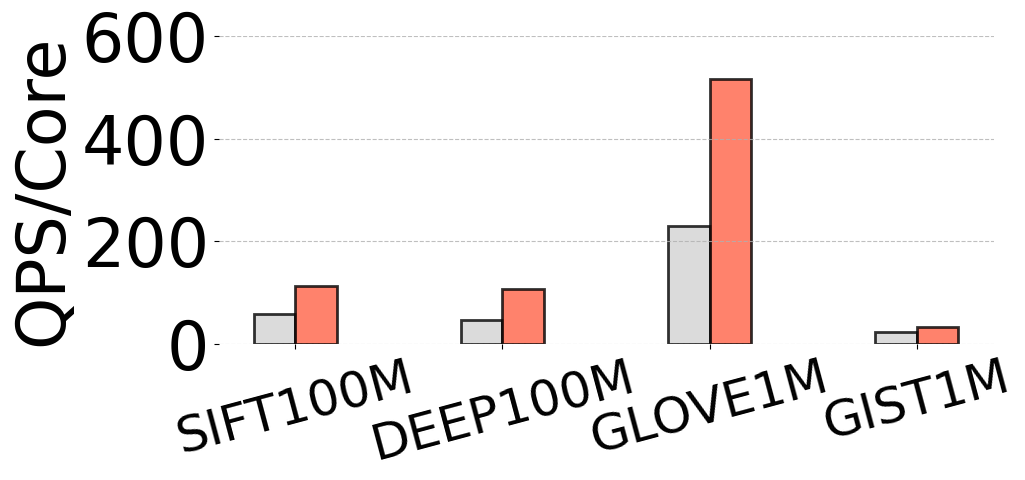

In [7]:
# Figure 10 with noise
# QPS graphs but with the actual achieved recall (not the recall target)

# todo here: find for 12% noise which multiplier/efsearch value gets the average recall to 0.9 for LAET and REM

multiplier_for_rt = {
    "SIFT100M": 0.5,
}
efsearch_for_rt = {
}
dists_for_rt = {
    
}

all_datasets = ["SIFT100M", "DEEP100M", "GLOVE100", "GIST1M"]#, "DEEP100M", "GLOVE100", "GIST1M", "T2I100M"]
all_dataset_labels = ["SIFT100M", "DEEP100M", "GLOVE1M", "GIST1M"]
all_k_values = ["50"]
all_r_targets = ["0.9"]
all_measures = ["QPS"]

plt.rcParams.update({"font.size": 48})
bar_width = 0.2

r_target = "0.9"
k = "50"

for noise_percentage in ["12"]:
    hnsw_QPS = []
    DARTH_QPS = []
    DARTH_speedups = []
    
    average_QPS_more_DARTH = 0
    average_speedup_more_DARTH = 0
    
    max_QPS_more_DARTH = 0
    max_speedup_more_DARTH = 0
    
    total_runs = 0
        
    for i, ds_name in enumerate(all_datasets):
        M, efS, efC = dataset_params[ds_name]["M"], dataset_params[ds_name]["efS"], dataset_params[ds_name]["efC"]

        ipi, mpi = interval_conf[ds_name][k][f"{float(r_target):.2f}"]["ipi"], interval_conf[ds_name][k][f"{float(r_target):.2f}"]["mpi"]
        f_r_target = float(r_target)
                    
        no_early_stop_df = pd.read_csv(f"../../experiments/results/no-early-stop/testing/{ds_name}/k{k}/noisy/noise{noise_percentage}_M{M}_efC{efC}_efS{efS}_qs{s}.txt", usecols=["qid", "step", "dists", "inserts", "elaps_ms", "r", "RDE", "TDR", "NRS"])
        achieved_plain_HNSW_recall = no_early_stop_df["r"].mean()
        
        no_early_stop_df = no_early_stop_df[no_early_stop_df["r"] >= f_r_target] # check this again and make sure no problems are caused by removing queries
        achieved_plain_HNSW_recall_1 = no_early_stop_df["r"].mean()           
                       
        darth_df = pd.read_csv(f"../../experiments/results/early-stop-testing/{ds_name}/k{k}/noisy/noise{noise_percentage}_M{M}_efC{efC}_efS{efS}_qs{s}_tr{f_r_target:.2f}_ipi{ipi}_mpi{mpi}.txt", usecols=["qid", "step", "dists", "inserts", "elaps_ms", "r_actual", "r_predicted", "r_predictor_calls", "r_predictor_time_ms", "RDE", "TDR", "NRS"])
        darth_df = darth_df[darth_df["qid"].isin(no_early_stop_df["qid"])]
                    
        achieved_recall_darth = darth_df["r_actual"].mean()
                    
        avg_no_early_term_query_time = no_early_stop_df["elaps_ms"].mean()
        avg_darth_query_time = darth_df["elaps_ms"].mean()
                    
        QPS_darth = 1/(avg_darth_query_time/1000)
        QPS_no_early_term = 1/(avg_no_early_term_query_time/1000)
                
        per_query_speedups = no_early_stop_df["elaps_ms"]/darth_df["elaps_ms"]
        DARTH_speedup = per_query_speedups.mean() 
        
        hnsw_QPS.append(QPS_no_early_term)
        DARTH_QPS.append(QPS_darth)
        DARTH_speedups.append(DARTH_speedup)
        
        #print(achieved_plain_HNSW_recall, achieved_plain_HNSW_recall_1, achieved_recall_darth)
        
        average_QPS_more_DARTH += QPS_darth - QPS_no_early_term
        average_speedup_more_DARTH += DARTH_speedup
        total_runs += 1
        
        max_QPS_more_DARTH = max(max_QPS_more_DARTH, QPS_darth - QPS_no_early_term)
        max_speedup_more_DARTH = max(max_speedup_more_DARTH, DARTH_speedup)
    
    print(f"Average QPS more DARTH: {average_QPS_more_DARTH / total_runs:.0f}")
    print(f"Average speedup more DARTH: {average_speedup_more_DARTH / total_runs:.2f}")
    print(f"Max QPS more DARTH: {max_QPS_more_DARTH:.0f}")
    print(f"Max speedup more DARTH: {max_speedup_more_DARTH:.2f}")
    
    fig, ax = plt.subplots(figsize=(10,4))
    
    x = np.arange(len(all_datasets))
    ax.bar(x - 0.5*bar_width, hnsw_QPS, width=bar_width, color=algorithm_conf["HNSW"]["color"], alpha=0.8, edgecolor="black", linewidth=2, label="HNSW", capsize=5)
    ax.bar(x + 0.5*bar_width, DARTH_QPS, width=bar_width, color=algorithm_conf["DARTH"]["color"], alpha=0.8, edgecolor="black", linewidth=2, label="DARTH", capsize=5)
    ax.grid(alpha=0.8, axis="y", linestyle="--")
    
    for spine in ax.spines.values():
        spine.set_visible(False)
            
    ax.set_xticks(np.arange(len(all_datasets)))
    ax.set_xticklabels(all_dataset_labels, rotation=15)
    plt.xticks(fontsize=36)
    ax.set_ylabel(f"QPS/Core")
    # set y ticks to be 0, 100, 200, 300, 400
    ticks = ax.get_yticks()
    ticks = [0, 200, 400, 600]
    ax.set_yticks(sorted(ticks))
            
    fig.savefig(f"{PLOTS_DIR}noisy{noise_percentage}_QPS_rt{r_target}_k{k}.pdf", bbox_inches="tight")
    print(f"Saved plot at {PLOTS_DIR}noisy{noise_percentage}_QPS_rt{r_target}_k{k}.pdf")
    
    plt.show()
    plt.close(fig)
    
    #fig, ax = plt.subplots(figsize=(10,6))
    #x = np.arange(len(all_datasets))
    #ax.bar(x, DARTH_speedups, width=bar_width, color=algorithm_conf["DARTH"]["color"], alpha=0.8, edgecolor="black", linewidth=2, label="DARTH", capsize=5)
    #ax.grid(alpha=0.8, axis="y", linestyle="--")
    
    #for spine in ax.spines.values():
    #    spine.set_visible(False)
            
    #ax.set_xticks(np.arange(len(all_datasets)))
    #ax.set_xticklabels(all_dataset_labels, rotation=45)
    #plt.xticks(fontsize=40)
    #ax.set_ylabel(f"Times Faster")
    # start y-axis at 1
    #ax.set_ylim(bottom=1)
            
    #fig.savefig(f"./plots/noisy{noise_percentage}_speedup_rt{r_target}_k{k}.pdf", bbox_inches="tight")
    #print(f"Saved plot at ./plots/noisy{noise_percentage}_speedup_rt{r_target}_k{k}.pdf")
    
    #plt.show()
    #plt.close(fig)
    
    


## Revision plan histograms

Speedup vs no early stop: 4.110396238355083
Recall DARTH: 0.9700710659898477 Recall HNSW: 0.9587208121827412
Queries DARTH: 225 Queries HNSW: 282
Queries DARTH: 225
Minimum recall of DARTH: 0.8000000000000002


Saved plot at ./../../experiments/plots/histogram_DEEP100M_k50_rt0.95.pdf


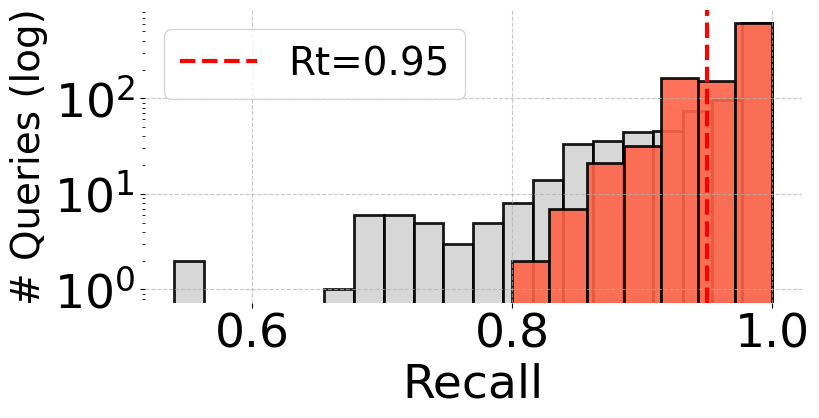

In [8]:
all_datasets = ["DEEP100M"]#["SIFT100M", "DEEP100M", "GLOVE100", "GIST1M"]
all_k_values = ["50"]#["10", "25", "50", "75", "100"]
all_r_targets = ["0.95"]# "0.95"]#, "0.99"]

plt.rcParams.update({"font.size": 34})
bar_width = 0.2
s = 1000


for i, ds_name in enumerate(all_datasets):
    M, efS, efC = dataset_params[ds_name]["M"], dataset_params[ds_name]["efS"], dataset_params[ds_name]["efC"]
   
    for r_target in all_r_targets:
                
        for k in all_k_values:
            ipi, mpi = interval_conf[ds_name][k][f"{float(r_target):.2f}"]["ipi"], interval_conf[ds_name][k][f"{float(r_target):.2f}"]["mpi"]
            f_r_target = float(r_target)
                    
            no_early_stop_df = pd.read_csv(f"../../experiments/results/no-early-stop/testing/{ds_name}/k{k}/M{M}_efC{efC}_efS{efS}_qs{s}.txt", usecols=["qid", "step", "dists", "inserts", "elaps_ms", "r", "RDE", "TDR", "NRS"])
            no_early_stop_df = no_early_stop_df[no_early_stop_df["r"] >= f_r_target]              
                    
            cefs = classic_hnsw_conf[ds_name][k][r_target]["min_efS"]
            
            noise_percentage = "0"
            if noise_percentage != "0":
                darth_df = pd.read_csv(f"../../experiments/results/early-stop-testing/{ds_name}/k{k}/noisy/noise{noise_percentage}_M{M}_efC{efC}_efS{efS}_qs{s}_tr{f_r_target:.2f}_ipi{ipi}_mpi{mpi}.txt", usecols=["qid", "step", "dists", "inserts", "elaps_ms", "r_actual", "r_predicted", "r_predictor_calls", "r_predictor_time_ms", "RDE", "TDR", "NRS"])
                hnsw_df  = pd.read_csv(f"../../experiments/results/classic-hnsw/{ds_name}/k{k}/noisy/noise{noise_percentage}_M{M}_efC{efC}_efS{cefs}_qs{s}_tr{f_r_target:.2f}.txt", usecols=["qid", "elaps_ms", "dists", "r", "RDE", "TDR", "NRS"])
            else:
                darth_df = pd.read_csv(f"../../experiments/results/early-stop-testing/{ds_name}/k{k}/M{M}_efC{efC}_efS{efS}_qs{s}_tr{f_r_target:.2f}_ipi{ipi}_mpi{mpi}.txt", usecols=["qid", "step", "dists", "inserts", "elaps_ms", "r_actual", "r_predicted", "r_predictor_calls", "r_predictor_time_ms", "RDE", "TDR", "NRS"])        
                hnsw_df  = pd.read_csv(f"../../experiments/results/classic-hnsw/{ds_name}/k{k}/M{M}_efC{efC}_efS{cefs}_qs{s}_tr{f_r_target:.2f}.txt", usecols=["qid", "elaps_ms", "dists", "r", "RDE", "TDR", "NRS"])
            
            # how many queries of DARTH have recall 1.00
            #darth_df = darth_df[darth_df["r_actual"] == 1.00]
            #print(len(darth_df))
            
            darth_df = darth_df[darth_df["qid"].isin(no_early_stop_df["qid"])]
            hnsw_df = hnsw_df[hnsw_df["qid"].isin(no_early_stop_df["qid"])]
                    
            recall_darth = darth_df["r_actual"].mean()
            recall_hnsw = hnsw_df["r"].mean()
            
            speedup_vs_no_early_stop = no_early_stop_df["elaps_ms"].mean() / darth_df["elaps_ms"].mean()
            print(f"Speedup vs no early stop: {speedup_vs_no_early_stop}")
            
            print(f"Recall DARTH: {recall_darth} Recall HNSW: {recall_hnsw}")
            
            darth_rqt = darth_df[darth_df["r_actual"] < f_r_target].shape[0]
            hnsw_rqt = hnsw_df[hnsw_df["r"] < f_r_target].shape[0]
            
            print(f"Queries DARTH: {darth_rqt} Queries HNSW: {hnsw_rqt}")
            print(f"Queries DARTH: {darth_rqt}")

            # what is the minimum recall of HNSW?
            #print(f"Minimum recall of HNSW: {hnsw_df['r'].min()}")
            print(f"Minimum recall of DARTH: {darth_df['r_actual'].min()}")
            
            # how many queries per HNSW bin?
            #print(hnsw_df["r"].value_counts())
            #print(darth_df["r_actual"].value_counts())
            
            fig, ax = plt.subplots(figsize=(9,5))
            ax.hist(hnsw_df["r"], alpha=0.9, label="", color=algorithm_conf["HNSW"]["color"], linewidth=2, edgecolor="black", bins=20)
            ax.hist(darth_df["r_actual"], alpha=0.9, label="", color=algorithm_conf["DARTH"]["color"], linewidth=2, edgecolor="black", bins=7)
            ax.axvline(x=f_r_target, color="red", linestyle="--", label=f"Rt={f_r_target}", linewidth=3)
            ax.legend(fontsize=28)
            ax.set_xlabel("Recall")
            ax.set_ylabel("# Queries (log)", fontsize=28)
            ax.grid(alpha=0.7, linestyle="--")    
                
            # protasi gia HNSW 0.99
            # ti recall kai speedup exei o DARTH 1
            # kai DARTH 99
                          
            # make y axis log:
            ax.set_yscale("log")     

            for spine in ax.spines.values():
                spine.set_visible(False)
            
            fig.tight_layout()
            if noise_percentage == "0":
                fig.savefig(f"../../experiments/plots/histogram_{ds_name}_k{k}_rt{r_target}.pdf", format="pdf", bbox_inches = 'tight')
                print(f"Saved plot at ./../../experiments/plots/histogram_{ds_name}_k{k}_rt{r_target}.pdf")
            else:
                fig.savefig(f"../../experiments/plots/histogram_noise{noise_percentage}_{ds_name}_k{k}_rt{r_target}.pdf", format="pdf", bbox_inches = 'tight')
                print(f"Saved plot at ./../../experiments/plots/histogram_noise{noise_percentage}_{ds_name}_k{k}_rt{r_target}.pdf")
                    

1000
890
Speedup vs no early stop: 1.2053777321287658
Queries DARTH: 3
Saved plot at ./../../experiments/plots/histogram_DEEP100M_k50_rt1.00.pdf


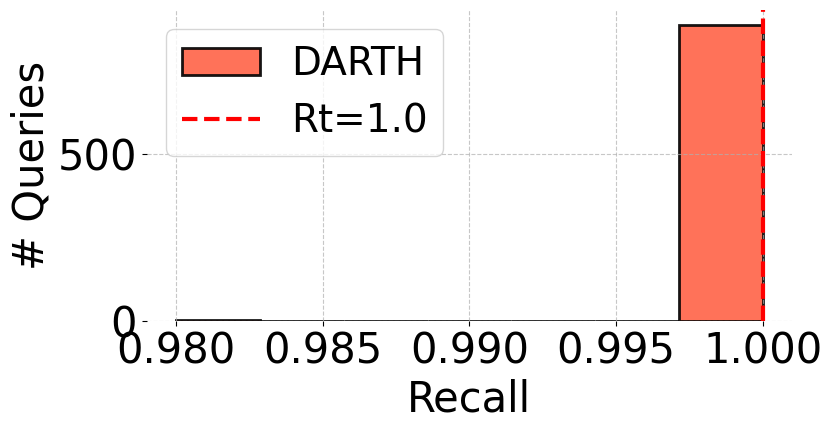

In [ ]:
all_datasets = ["DEEP100M"]#["SIFT100M", "DEEP100M", "GLOVE100", "GIST1M"]
all_k_values = ["50"]#["10", "25", "50", "75", "100"]
all_r_targets = ["1.00"]# "0.95"]#, "0.99"]

plt.rcParams.update({"font.size": 30})
bar_width = 0.2
s = 1000


for i, ds_name in enumerate(all_datasets):
    M, efS, efC = dataset_params[ds_name]["M"], dataset_params[ds_name]["efS"], dataset_params[ds_name]["efC"]
   
    for r_target in all_r_targets:
                
        for k in all_k_values:
            ipi, mpi = 4011, 802#interval_conf[ds_name][k][f"{float(r_target):.2f}"]["ipi"], interval_conf[ds_name][k][f"{float(r_target):.2f}"]["mpi"]
            f_r_target = 1.00#float(r_target)
                    
            no_early_stop_df = pd.read_csv(f"../../experiments/results/no-early-stop/testing/{ds_name}/k{k}/M{M}_efC{efC}_efS{efS}_qs{s}.txt", usecols=["qid", "step", "dists", "inserts", "elaps_ms", "r", "RDE", "TDR", "NRS"])
            print(len(no_early_stop_df))
            no_early_stop_df = no_early_stop_df[no_early_stop_df["r"] >= f_r_target]              
            print(len(no_early_stop_df))
            
            darth_df = pd.read_csv(f"../../experiments/results/early-stop-testing/{ds_name}/k{k}/M{M}_efC{efC}_efS{efS}_qs{s}_tr{f_r_target}_ipi{ipi}_mpi{mpi}.txt", usecols=["qid", "step", "dists", "inserts", "elaps_ms", "r_actual", "r_predicted", "r_predictor_calls", "r_predictor_time_ms", "RDE", "TDR", "NRS"])        
  
            darth_df = darth_df[darth_df["qid"].isin(no_early_stop_df["qid"])]
                    
            recall_darth = darth_df["r_actual"].mean()
            
            speedup_vs_no_early_stop = no_early_stop_df["elaps_ms"].mean() / darth_df["elaps_ms"].mean()
            print(f"Speedup vs no early stop: {speedup_vs_no_early_stop}")
            
            darth_rqt = darth_df[darth_df["r_actual"] < f_r_target].shape[0]
            hnsw_rqt = hnsw_df[hnsw_df["r"] < f_r_target].shape[0]
            
            print(f"Queries DARTH: {darth_rqt}")

            
            fig, ax = plt.subplots(figsize=(9,5))
            #ax.hist(hnsw_df["r"], alpha=0.9, label="REM", color=algorithm_conf["HNSW"]["color"], linewidth=2, edgecolor="black", bins=20)
            ax.hist(darth_df["r_actual"], alpha=0.9, label="DARTH", color=algorithm_conf["DARTH"]["color"], linewidth=2, edgecolor="black", bins=7)
            ax.axvline(x=f_r_target, color="red", linestyle="--", label=f"Rt={f_r_target}", linewidth=3)
            ax.legend(fontsize=28)
            ax.set_xlabel("Recall")
            ax.set_ylabel("# Queries")
            ax.grid(alpha=0.7, linestyle="--")     
        
            for spine in ax.spines.values():
                spine.set_visible(False)
            
            fig.tight_layout()
            fig.savefig(f"../../experiments/plots/histogram_{ds_name}_k{k}_rt{r_target}.pdf", format="pdf", bbox_inches = 'tight')
            print(f"Saved plot at ./../../experiments/plots/histogram_{ds_name}_k{k}_rt{r_target}.pdf")
           